In [1]:
# import libraryies
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
import time  
import seaborn as sns 
sns.set(color_codes=True)

sys.path.append('lib')  
import NNDP_Embeddings as emb
import SNP_processing as snpp
import NNDP_Visualization as vis 

emb2simi=emb.embedding_vector()
sp = snpp.SNP_processor()
vi = vis.NNDP_Visualization()

In [2]:
# load SNP data and labels (MI event age, race) 
ori_X = np.load('../data/SNP_data/X.dat', allow_pickle=True)
y_MI = np.load('../data/SNP_data/y_MI.dat', allow_pickle=True)
y_race = np.load('../data/SNP_data/y_race.dat', allow_pickle=True)

#load ID
rsid_indexs = np.load('../data/SNP_data/rsid_indexs.dat', allow_pickle=True) 
RsId2symble_values = np.load('../data/SNP_data/RsId2symble_values.dat', allow_pickle=True)
RsId2symble_keys = np.load('../data/SNP_data/RsId2symble_keys.dat', allow_pickle=True)

RsId2symble = {}
for i in range(len(RsId2symble_keys)):
    RsId2symble[RsId2symble_keys[i]] = RsId2symble_values[i]

In [3]:
def Literature_based_SNP(embeding_X0, data, full_size, indices):
    reduced_emb0 = embeding_X0[indices[:full_size],:] # extract 6,400 feature-related embedding vectors
    LiterSNP=np.matmul(data, reduced_emb0)
    scaler = StandardScaler()
    scaler.fit(LiterSNP)
    LiterSNP = scaler.transform(LiterSNP)
    return LiterSNP

In [4]:
def Standardization(_X_train, _X_test):
    scaler = StandardScaler()
    scaler.fit(_X_train)
    X_train = scaler.transform(_X_train)
    scaler.fit(_X_test)
    X_test = scaler.transform(_X_test)
    
    return X_train, X_test

In [5]:
def RF_FS(X_train, y_MI_train):
    rnd_clf = RandomForestClassifier(n_estimators= 128, max_features= 128, random_state=15)   
    
    #print(best_param)
    rnd_clf.fit(X_train, y_MI_train) 
    values=rnd_clf.feature_importances_ 
    indices = np.argsort(values).tolist()
    indices = indices[::-1]
    return indices

In [6]:
def Visualization_Analysis(X_train, y_train1, y_train2, X_test, y_test1, y_test2, name):   
    from sklearn.decomposition import PCA 
    import matplotlib.pyplot as plt
    import numpy as np
    import umap  
    
    pca = PCA(n_components=2)
    projected_ebd = pca.fit_transform(X_train) 
    st=time.time()
    projected_ebd_test = pca.fit_transform(X_test) 
    ed=time.time()
    print('PCA operation at testing data :', ed-st)
    
    Xax=projected_ebd[:,0]; Yax=projected_ebd[:,1] 
    Xax_test=projected_ebd_test[:,0]; Yax_test=projected_ebd_test[:,1] 
    labels=y_train1; labels2=y_train2; labels_test=y_test1; labels2_test=y_test2 

    cdict={0:'tab:blue',1:'tab:orange',2:'yellowgreen',3:'tab:red',4:'tab:purple'}
    labl1={1:'MI event age 20-49',0:'MI event age 50-60'} 
    labl2={0:'Black',1:'European', 2:'Unknown', 3:'Other', 4:'Hispanic'}
    
    ## PCA for MI event age group
    
    plt.figure(1, figsize=(5,5))
    fig,ax=plt.subplots(figsize=(6,4))
    fig.patch.set_facecolor('white')
    for l in np.unique(labels):
        ix=np.where(labels==l)
        ax.scatter(Xax[ix],Yax[ix],s=40,alpha=0.8,c=cdict[l],
                   label=labl1[l])   

    plt.legend(prop={'size': 14})      
    fig.patch.set_facecolor('white')
    for l in np.unique(labels_test):
        ix=np.where(labels_test==l)
        ax.scatter(Xax_test[ix],Yax_test[ix],s=40,alpha=0.4, c=cdict[l],
                   label=labl1[l])
    plt.xlabel("First PCA",fontsize=14)
    plt.ylabel("Second PCA",fontsize=14) 
    plt.title(name)
    plt.show()     
    
    ## PCA for MI with race
    
    cdict={0:'tab:blue',1:'tab:orange',2:'yellowgreen',3:'tab:red',4:'tab:purple'}
    labl3={0:'Black, MI event <50',1:'Black, MI event ≥50', 2:'European, MI event <50', 3:'European, MI event ≥50', 4:'Other'}
    marker={0:'o',1:'o', 2:'o', 3:'o'}
    alpha={0:0.8, 1:0.7}
    
    plt.figure(2, figsize=(7,5))
    fig,ax=plt.subplots(figsize=(8,5))
    fig.patch.set_facecolor('white')
    
    for l in np.unique(labels2):
        ix=np.where(labels2==l)
        ax.scatter(Xax[ix],Yax[ix],s=40,alpha=0.8, c=cdict[l],
                   label=labl3[l])

    plt.legend(prop={'size': 13})     
    fig.patch.set_facecolor('white')
    for l in np.unique(labels2_test):
        ix=np.where(labels2_test==l)
        ax.scatter(Xax_test[ix],Yax_test[ix],s=40,alpha=0.4, c=cdict[l])
    plt.xlabel("First PCA",fontsize=14)
    plt.ylabel("Second PCA",fontsize=14)
    plt.title(name)
    plt.show()  

    ## UMAP for MI event age group
    
    plt.figure(3, figsize=(5,5))
    up = umap.UMAP(n_components=2, random_state=42)
    up.fit(X_train) 
    projected_ebd = up.transform(X_train) 
    st=time.time()
    projected_ebd_test = up.transform(X_test) 
    ed=time.time()
    print('UMAP operation at testing data :', ed-st)
    
    Xax=projected_ebd[:,0]
    Yax=projected_ebd[:,1] 
    Xax_test=projected_ebd_test[:,0]
    Yax_test=projected_ebd_test[:,1]  
    
    fig,ax=plt.subplots(figsize=(6,4))
    fig.patch.set_facecolor('white')
    for l in np.unique(labels):
        ix=np.where(labels==l)
        ax.scatter(Xax[ix],Yax[ix],s=40,alpha=0.8, c=cdict[l],
                   label=labl1[l])

    plt.legend(prop={'size': 14})     
    fig.patch.set_facecolor('white')
    for l in np.unique(labels_test):
        ix=np.where(labels_test==l)
        ax.scatter(Xax_test[ix],Yax_test[ix],s=40,alpha=0.4, c=cdict[l],
                   label=labl1[l])
    plt.xlabel("First UMAP",fontsize=14)
    plt.ylabel("Second UMAP",fontsize=14)
    plt.title(name)
    plt.show()       
    
    ## UMAP for MI with race
    
    plt.figure(4, figsize=(7,5))
    cdict={0:'tab:blue',1:'tab:orange',2:'yellowgreen',3:'tab:red',4:'tab:purple'}
    labl3={0:'Black, MI event <50',1:'Black, MI event ≥50', 2:'European, MI event <50', 3:'European, MI event ≥50', 4:'Other'}
    marker={0:'o',1:'o', 2:'o', 3:'o'}
    alpha={0:0.8, 1:0.7}#, 2:1, 3:1} 
    
    fig,ax=plt.subplots(figsize=(8,5))
    fig.patch.set_facecolor('white')
    for l in np.unique(labels2):
        ix=np.where(labels2==l)
        ax.scatter(Xax[ix],Yax[ix],s=40,alpha=0.8, c=cdict[l],
                   label=labl3[l])

    plt.legend(prop={'size': 13})   
    fig.patch.set_facecolor('white')
    for l in np.unique(labels2_test):
        ix=np.where(labels2_test==l)
        ax.scatter(Xax_test[ix],Yax_test[ix],s=40,alpha=0.4, c=cdict[l])
    plt.xlabel("First UMAP",fontsize=14)
    plt.ylabel("Second UMAP",fontsize=14) 
    plt.title(name)
    plt.show()  

In [7]:
def re_labeling(y1, y2):
    y3=[]
    for i in range(len(y1)):
        if y1[i]==0 and y2[i]==1:
            y3.append(0)
        elif y1[i]==0 and y2[i]==0:
            y3.append(1)
        elif y1[i]==1 and y2[i]==1:
            y3.append(2)
        elif y1[i]==1 and y2[i]==0:
            y3.append(3)
        else:
            y3.append(4)
    return np.array(y3) 

In [8]:
full_size = 128*50 # 6,400 features

C:\Users\jim19007\Anaconda3\envs\visualization\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PCA operation at testing data : 0.032910823822021484


<Figure size 500x500 with 0 Axes>

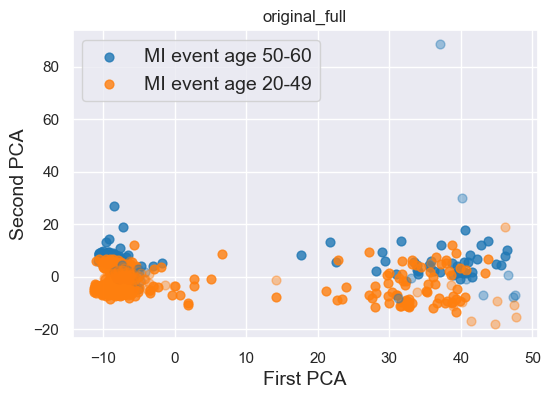

<Figure size 700x500 with 0 Axes>

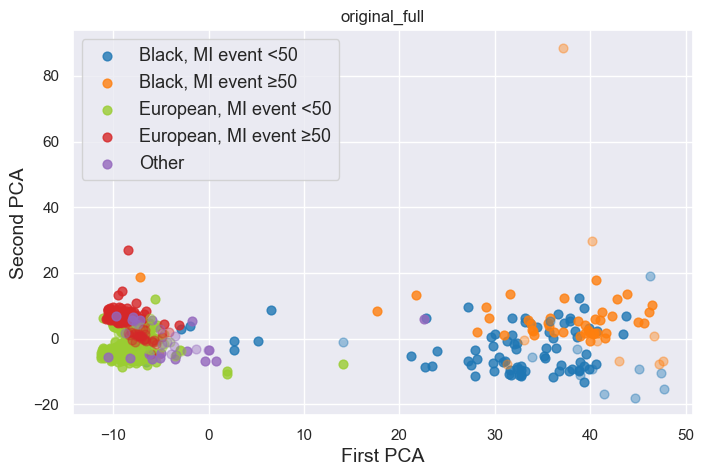

UMAP operation at testing data : 5.662294387817383


<Figure size 500x500 with 0 Axes>

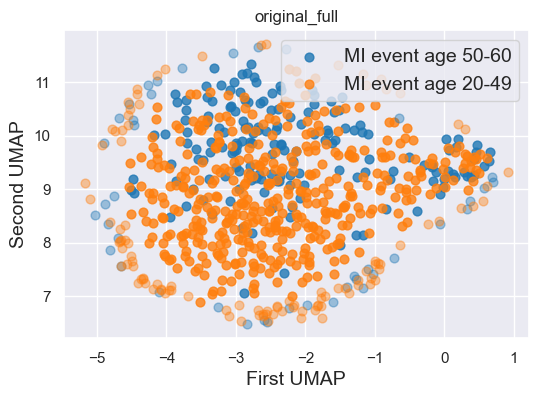

<Figure size 700x500 with 0 Axes>

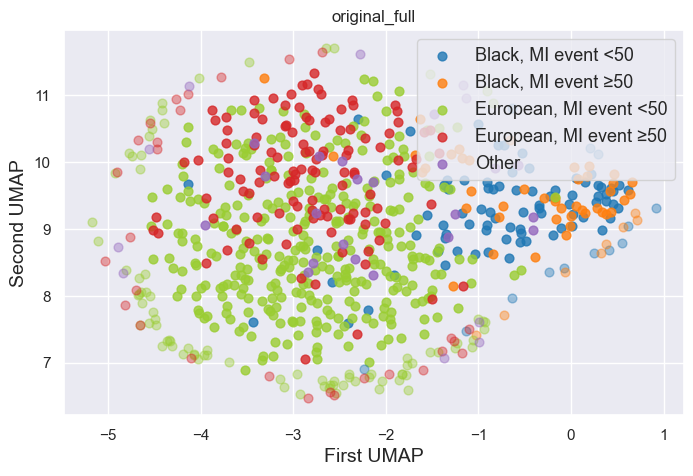

In [9]:
ori_X_ = ori_X.copy()
X_train, X_test, y_MI_train, y_MI_test, y_race_train, y_race_test, _ = vi.demo_cleaning_data_raw_version(ori_X_, y_MI, y_race, full_size)
y_mixed_train = re_labeling(y_race_train, y_MI_train)
y_mixed_test = re_labeling(y_race_test,y_MI_test)
Visualization_Analysis(X_train,y_MI_train, y_mixed_train, X_test,y_MI_test, y_mixed_test, 'original_full')

PCA operation at testing data : 0.018949270248413086


<Figure size 500x500 with 0 Axes>

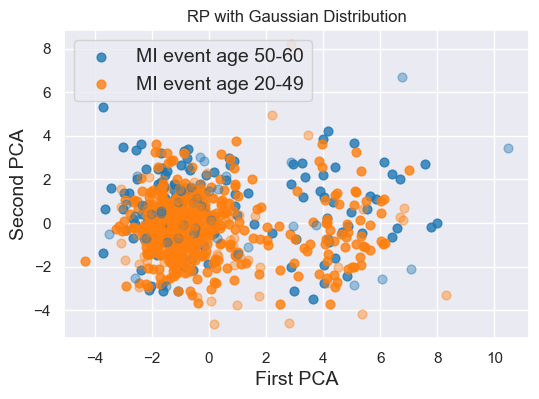

<Figure size 700x500 with 0 Axes>

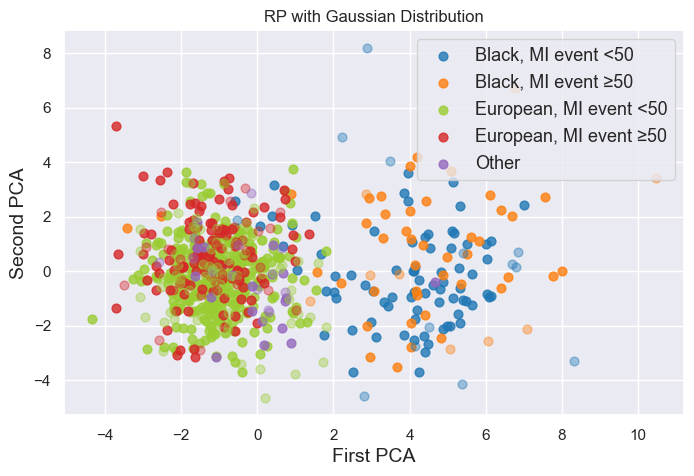

UMAP operation at testing data : 0.9561336040496826


<Figure size 500x500 with 0 Axes>

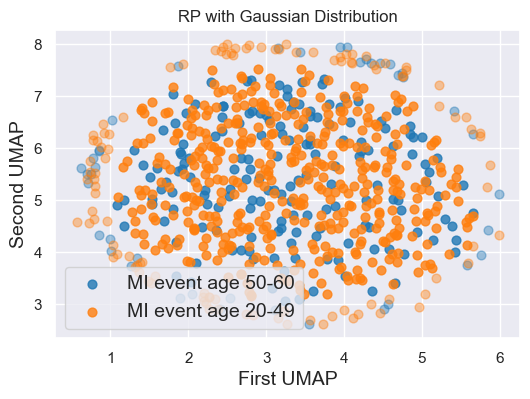

<Figure size 700x500 with 0 Axes>

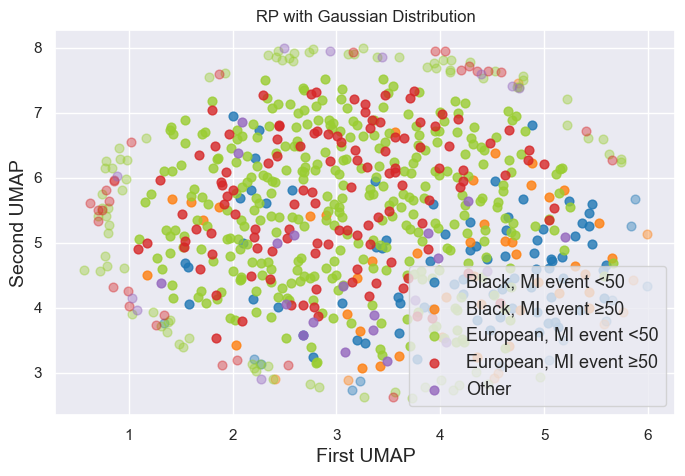

------- RP with Gaussian Distribution


In [10]:
def making_gaussian(full=1024, dim=128):
    Gaussian_RD=[]
    mu, sigma = 0, 1
    Gaussian_RD = np.random.normal(mu, sigma, full*dim)
    return np.array(Gaussian_RD).reshape(full,dim)

reduced_emb_gau = making_gaussian(full_size, 128) # generating gaussian distribution

_G1=np.matmul(X_train, reduced_emb_gau)  # Random Projection (RP)
_G2=np.matmul(X_test, reduced_emb_gau)  # Random Projection (RP)

G1, G2 = Standardization(_G1, _G2)

Visualization_Analysis(G1,y_MI_train, y_mixed_train, G2,y_MI_test, y_mixed_test, 'RP with Gaussian Distribution')
print('------- RP with Gaussian Distribution')

PCA operation at testing data : 0.01595759391784668


<Figure size 500x500 with 0 Axes>

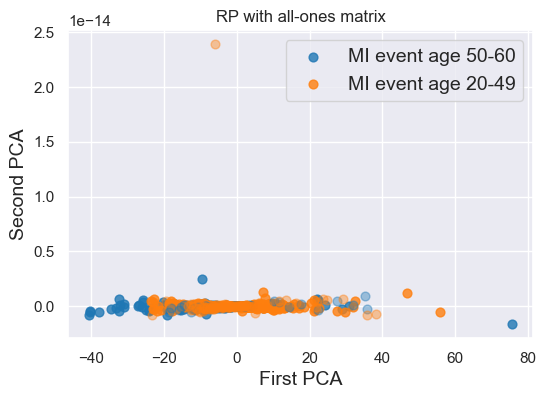

<Figure size 700x500 with 0 Axes>

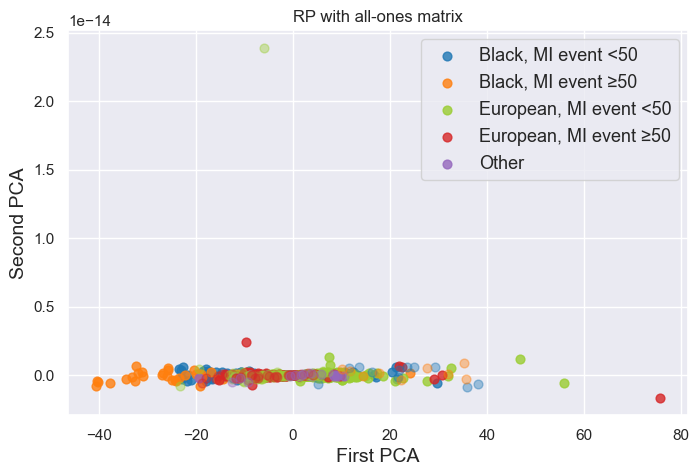

UMAP operation at testing data : 0.936939001083374


<Figure size 500x500 with 0 Axes>

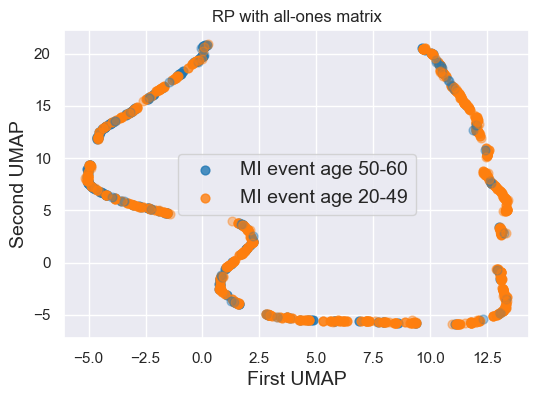

<Figure size 700x500 with 0 Axes>

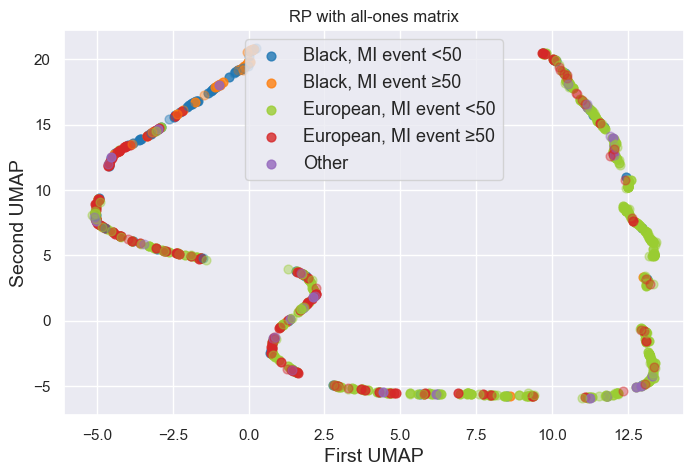

------- RP with all-ones matrix


In [11]:
def making_all_ones(full=1024, dim=128):
    RD=[] 
    for i in range(full):
        s = np.ones(dim)
        RD.append(s)
    return np.array(RD)

reduced_emb_ones = making_all_ones(full_size, 128) # generating gaussian distribution

_O1=np.matmul(X_train, reduced_emb_ones)  # Random Projection (RP)
_O2=np.matmul(X_test, reduced_emb_ones)  # Random Projection (RP)

O1, O2 = Standardization(_O1, _O2)

Visualization_Analysis(O1,y_MI_train, y_mixed_train, O2,y_MI_test, y_mixed_test, 'RP with all-ones matrix')
print('------- RP with all-ones matrix') # We did not include the result in our manuscript because it was not necessary. We only presented it for demonstration purposes :)

-------------- Embedding for NNDP :  IN


INFO:tensorflow:Restoring parameters from ../embeddings/literature_embedding/model.ckpt
in-of-vocab:  heart 2069
	 heart 1.0
	 cardiac 0.718727
	 ventricular 0.57835436
	 cardiomyocytes 0.50018597
	 hypertrophy 0.44523877
	 mir101a 0.44420275
	 barx1 0.43658942
	 nkx2-1 0.41945916
	 ddi2 0.40641326
	 vsmcs 0.4057696
arrange the embedding matrix per SNP index
removing SNP that has missing of > 5%
removing some embedding vectors that matached with removed SNP
spliting data into training and testing sets
PCA operation at testing data : 0.020943880081176758


<Figure size 500x500 with 0 Axes>

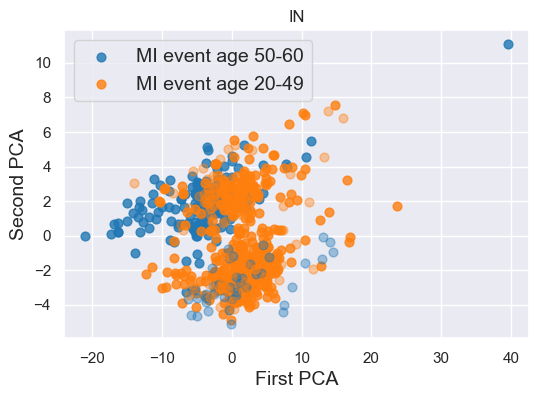

<Figure size 700x500 with 0 Axes>

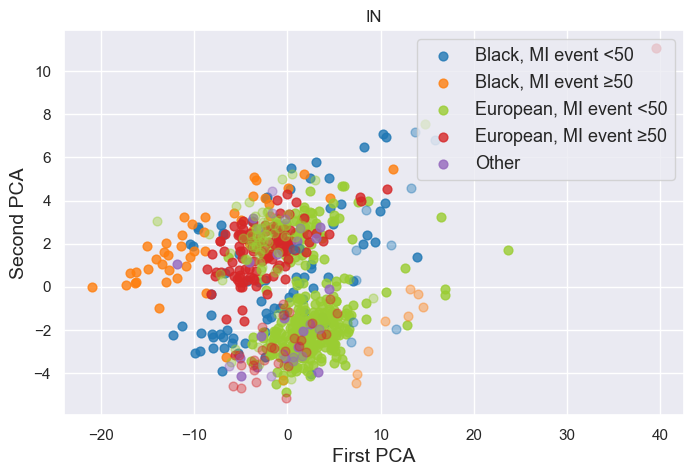

UMAP operation at testing data : 0.9793922901153564


<Figure size 500x500 with 0 Axes>

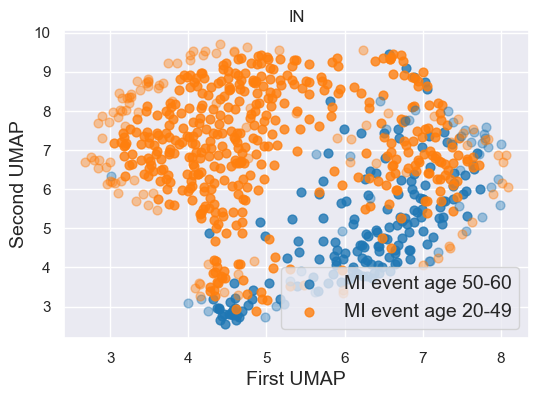

<Figure size 700x500 with 0 Axes>

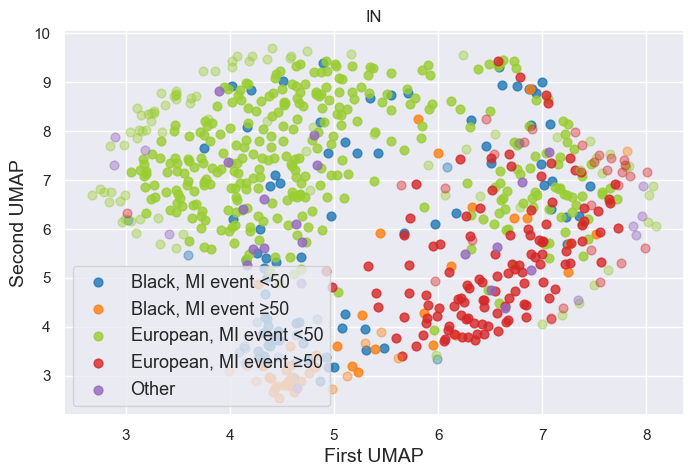

-------------- Embedding for NNDP :  OUT
INFO:tensorflow:Restoring parameters from ../embeddings/literature_embedding/model.ckpt
in-of-vocab:  heart 2069
	 heart 1.0
	 cntfets 0.98459065
	 aoah-# 0.98390454
	 gbmscs 0.9836718
	 sub-saharan 0.983178
	 parker 0.98315483
	 cdc13 0.9831444
	 hfq 0.9831289
	 single-transmembrane 0.9828528
	 aries_v4 0.9828278
arrange the embedding matrix per SNP index
removing SNP that has missing of > 5%
removing some embedding vectors that matached with removed SNP
spliting data into training and testing sets
PCA operation at testing data : 0.01695394515991211


<Figure size 500x500 with 0 Axes>

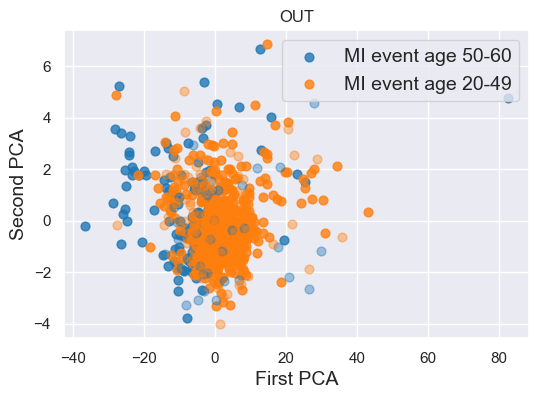

<Figure size 700x500 with 0 Axes>

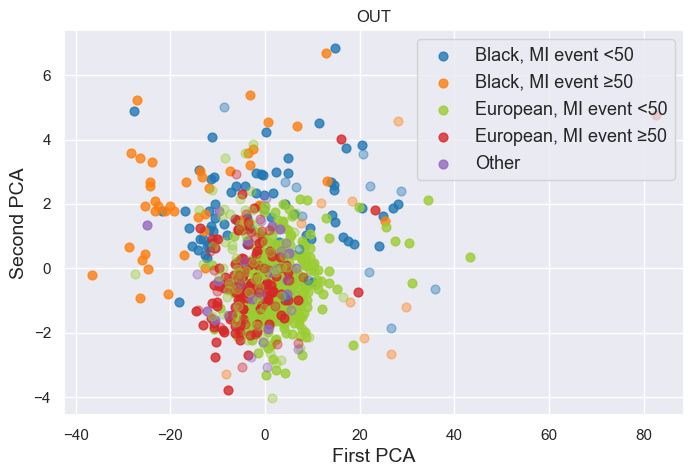

UMAP operation at testing data : 1.0623154640197754


<Figure size 500x500 with 0 Axes>

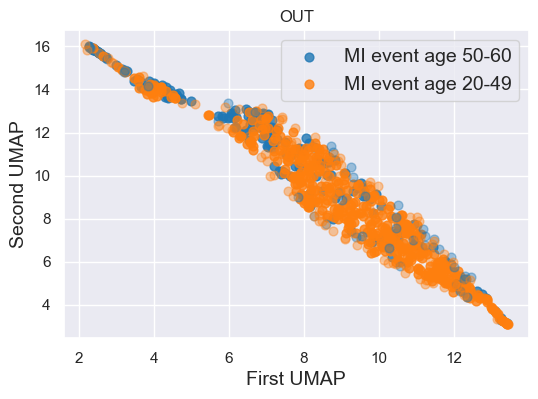

<Figure size 700x500 with 0 Axes>

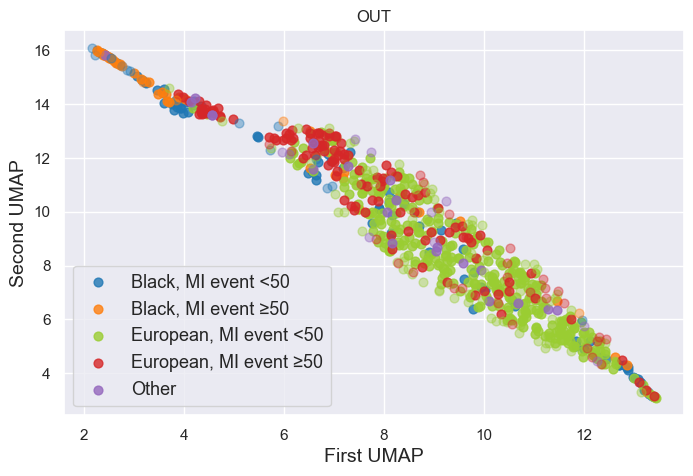

-------------- Embedding for NNDP :  Word2Vec
in-of-vocab:  heart 417
	 heart 1.0
	 kidney 0.6758258
	 cardiac 0.66244304
	 ventricular 0.59118867
	 myocardium 0.58893263
	 cardiovascular 0.551167
	 myocardial 0.5304567
	 eye 0.5286638
	 liver 0.52289194
	 organ 0.5190049
arrange the embedding matrix per SNP index
removing SNP that has missing of > 5%
removing some embedding vectors that matached with removed SNP
spliting data into training and testing sets
PCA operation at testing data : 0.02013540267944336


<Figure size 500x500 with 0 Axes>

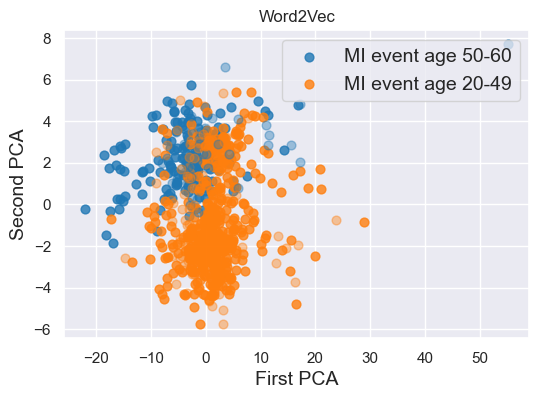

<Figure size 700x500 with 0 Axes>

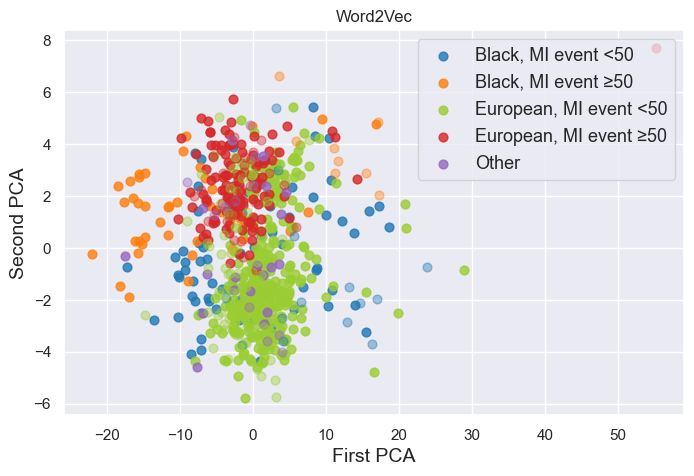

UMAP operation at testing data : 1.1234683990478516


<Figure size 500x500 with 0 Axes>

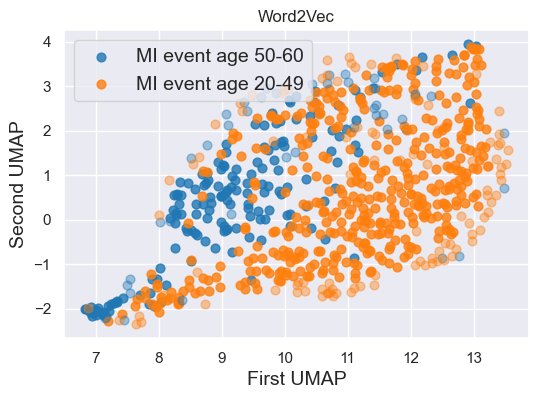

<Figure size 700x500 with 0 Axes>

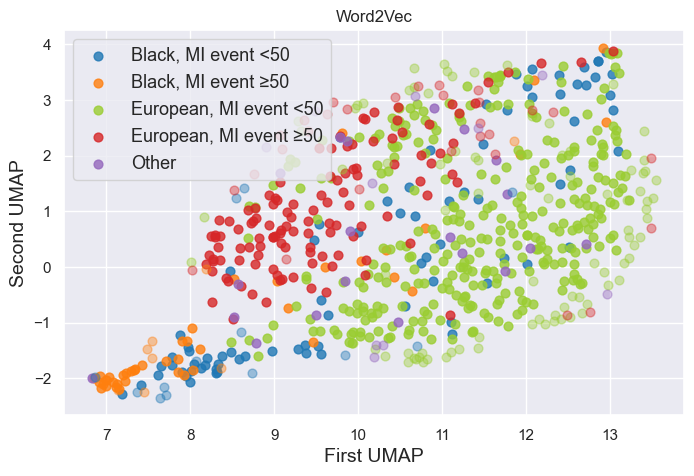

-------------- Embedding for NNDP :  GloVe
in-of-vocab:  heart 417
	 heart 1.0
	 healthy-type 0.9225394432713225
	 dallas 0.9081322103133129
	 failure-relevant 0.8810625516142464
	 jogging 0.8243548707723696
	 failure-related 0.8165232106767208
	 murmur 0.8113493478681691
	 tsp-1ko 0.7858024656161249
	 conotruncal 0.7753603742584383
	 arvms 0.7728403523153
arrange the embedding matrix per SNP index
removing SNP that has missing of > 5%
removing some embedding vectors that matached with removed SNP
spliting data into training and testing sets
PCA operation at testing data : 0.021962404251098633


<Figure size 500x500 with 0 Axes>

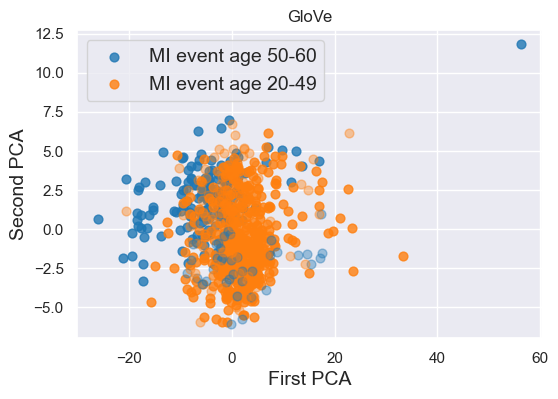

<Figure size 700x500 with 0 Axes>

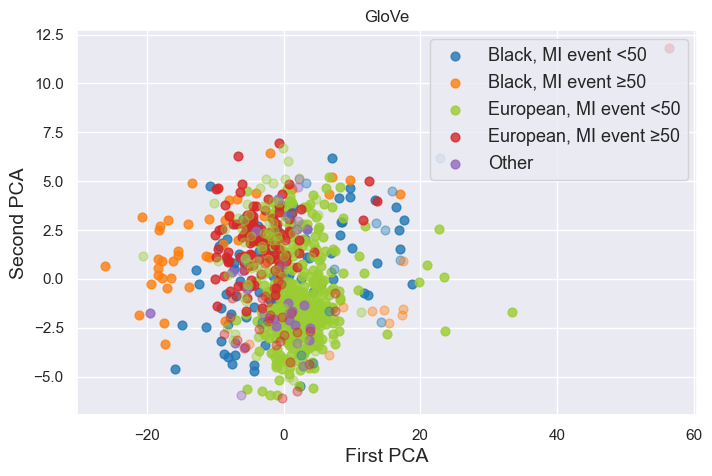

UMAP operation at testing data : 1.008284330368042


<Figure size 500x500 with 0 Axes>

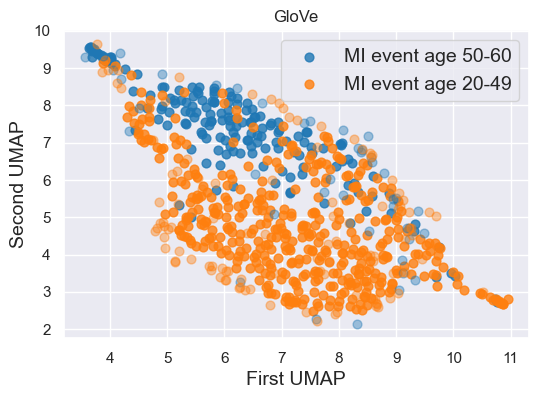

<Figure size 700x500 with 0 Axes>

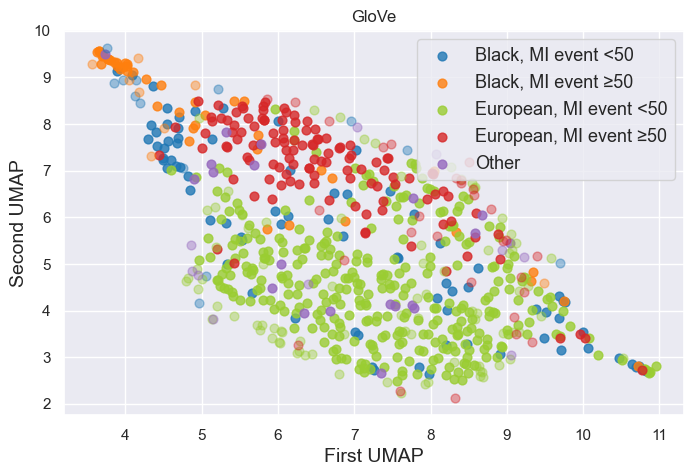

-------------- Embedding for NNDP :  FastText
in-of-vocab:  heart 418
	 heart 0.9999999999999999
	 canheart 0.8038003869602697
	 hearth 0.7963393415997446
	 cardiac 0.7646930530880056
	 brain-heart 0.752495607885922
	 heartworm 0.7488512547652774
	 heart-# 0.7345033274772516
	 life-heart 0.7293405401696345
	 myocardium 0.7261220289314332
	 heartburn 0.7260981120022778
arrange the embedding matrix per SNP index
removing SNP that has missing of > 5%
removing some embedding vectors that matached with removed SNP
spliting data into training and testing sets
PCA operation at testing data : 0.017951011657714844


<Figure size 500x500 with 0 Axes>

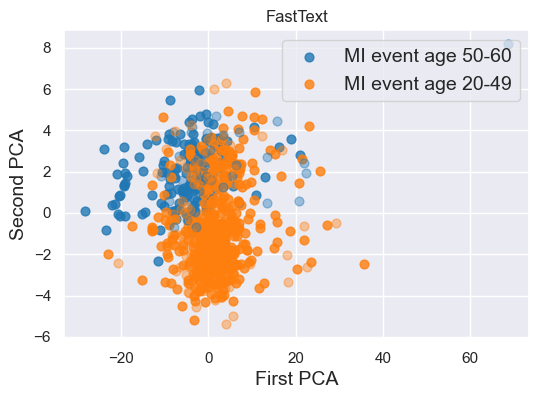

<Figure size 700x500 with 0 Axes>

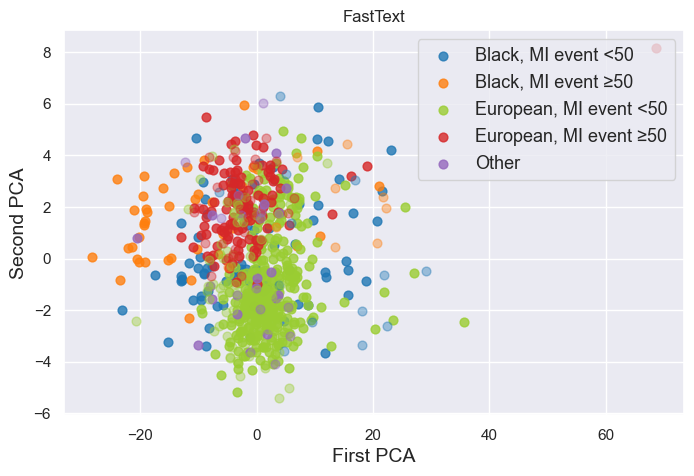

UMAP operation at testing data : 1.0566551685333252


<Figure size 500x500 with 0 Axes>

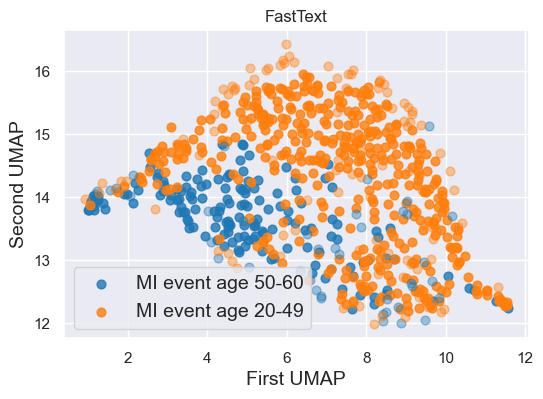

<Figure size 700x500 with 0 Axes>

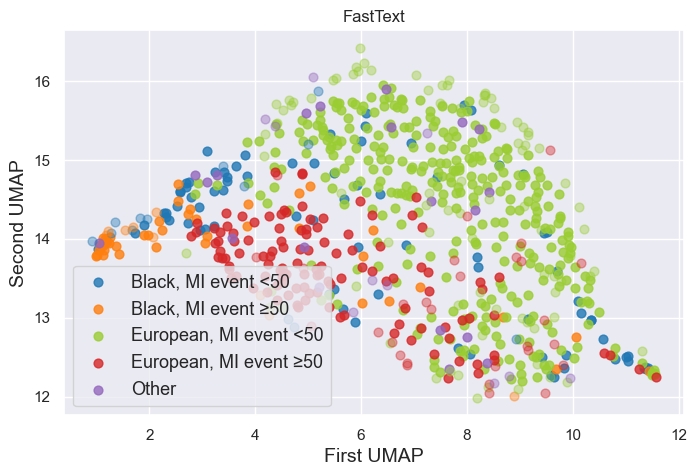

-------------- Embedding for NNDP :  ELMo
in-of-vocab:  heart 2069
	 heart 1.0
	 kidney 0.8342253
	 eye 0.78370804
	 brain 0.765978
	 peri-ictal 0.7394867
	 hearth 0.7310007
	 liver 0.7269245
	 episcleral 0.72452646
	 semi-solid 0.7231071
	 dent 0.7209209
arrange the embedding matrix per SNP index
removing SNP that has missing of > 5%
removing some embedding vectors that matached with removed SNP
spliting data into training and testing sets
PCA operation at testing data : 0.01695418357849121


<Figure size 500x500 with 0 Axes>

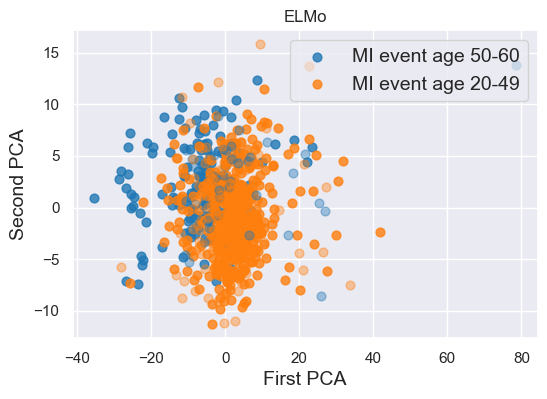

<Figure size 700x500 with 0 Axes>

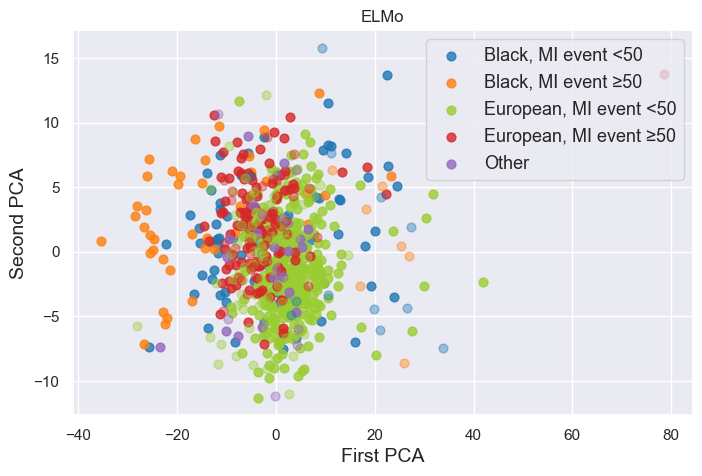

UMAP operation at testing data : 0.9256083965301514


<Figure size 500x500 with 0 Axes>

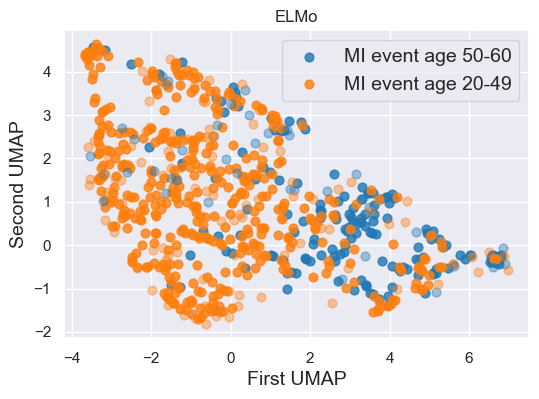

<Figure size 700x500 with 0 Axes>

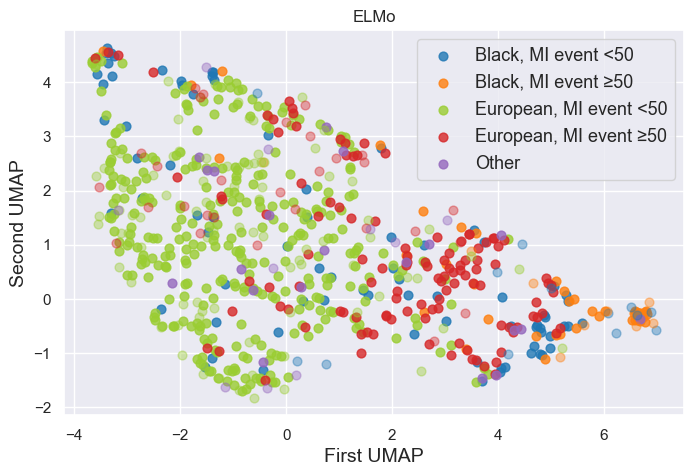

-------------- Embedding for NNDP :  GPT2
in-of-vocab:  heart 2069
	 heart 1.0
	 hot 0.92972
	 hbmec 0.9282126
	 hnpgs 0.9271559
	 hatched 0.9265821
	 hle-b3 0.9258313
	 h2afz 0.9241622
	 hdsp 0.92408264
	 hmgbs 0.92396337
	 hffs 0.92349637
arrange the embedding matrix per SNP index
removing SNP that has missing of > 5%
removing some embedding vectors that matached with removed SNP
spliting data into training and testing sets
PCA operation at testing data : 0.01795220375061035


<Figure size 500x500 with 0 Axes>

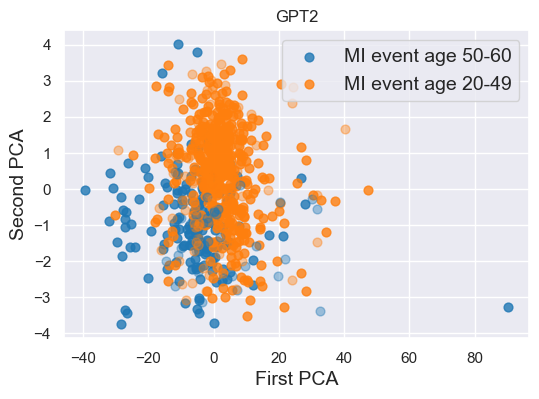

<Figure size 700x500 with 0 Axes>

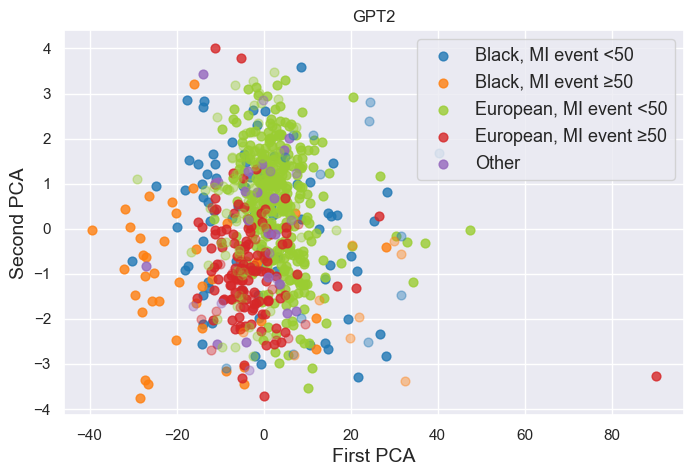

UMAP operation at testing data : 1.136040449142456


<Figure size 500x500 with 0 Axes>

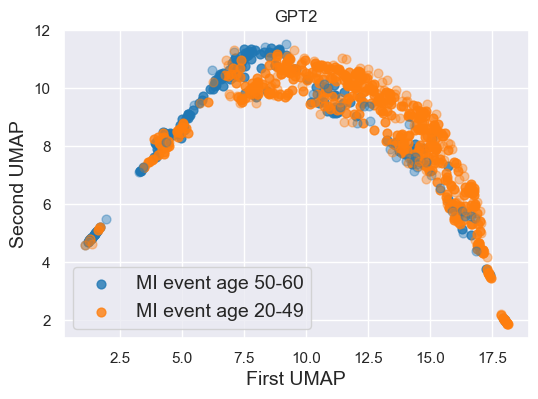

<Figure size 700x500 with 0 Axes>

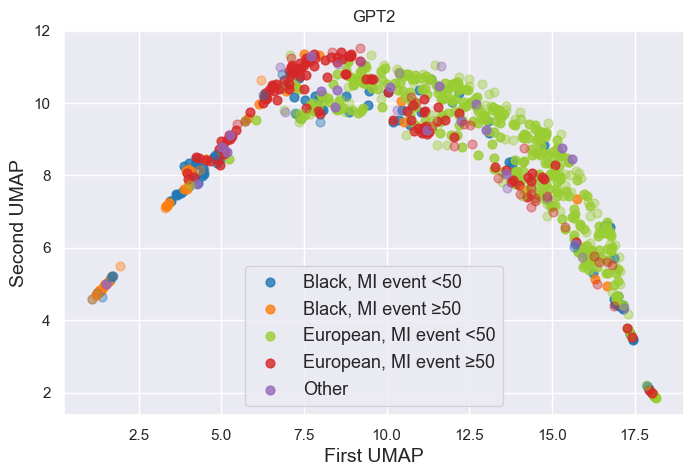

-------------- Embedding for NNDP :  ALBERT_i
in-of-vocab:  heart 2069
	 heart 1.0
	 hearth 0.77593845
	 heartburn 0.7583503
	 hearts 0.7161468
	 brain-heart 0.69714606
	 heartworm 0.6628323
	 life-heart 0.61936367
	 cardiac 0.6122365
	 heart-directed 0.5549564
	 heart-enriched 0.554195
arrange the embedding matrix per SNP index
removing SNP that has missing of > 5%
removing some embedding vectors that matached with removed SNP
spliting data into training and testing sets
PCA operation at testing data : 0.018949031829833984


<Figure size 500x500 with 0 Axes>

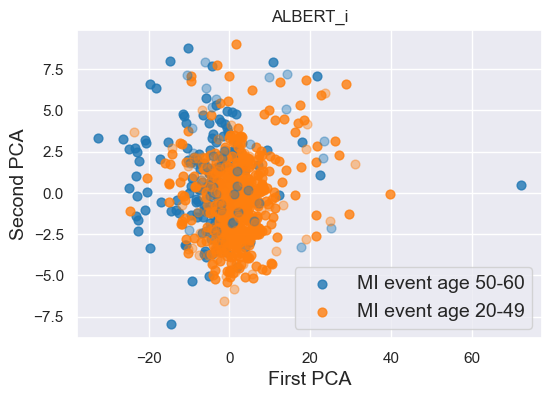

<Figure size 700x500 with 0 Axes>

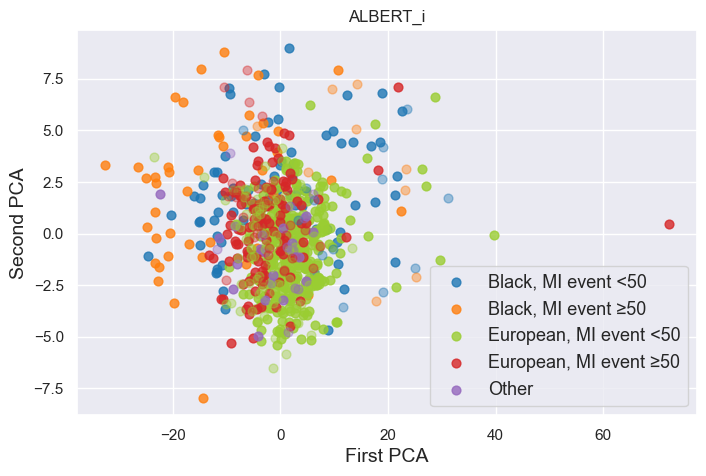

UMAP operation at testing data : 1.0202815532684326


<Figure size 500x500 with 0 Axes>

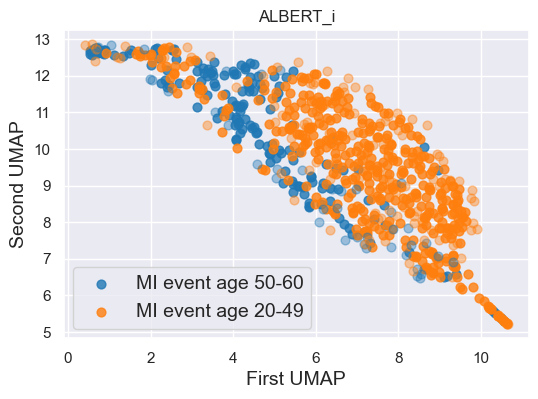

<Figure size 700x500 with 0 Axes>

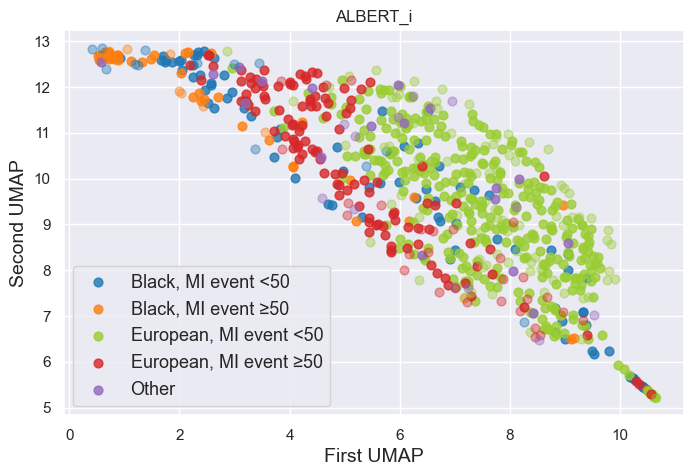

-------------- Embedding for NNDP :  ALBERT_d
in-of-vocab:  heart 2069
	 heart 1.0
	 body 0.65977323
	 pancreatic 0.61319995
	 hearts 0.6067444
	 chd8 0.57176316
	 shr-lx 0.566431
	 epicardial 0.5628252
	 dies 0.5573331
	 bone-regeneration 0.5543926
	 whole-muscle 0.551339
arrange the embedding matrix per SNP index
removing SNP that has missing of > 5%
removing some embedding vectors that matached with removed SNP
spliting data into training and testing sets
PCA operation at testing data : 0.016953706741333008


<Figure size 500x500 with 0 Axes>

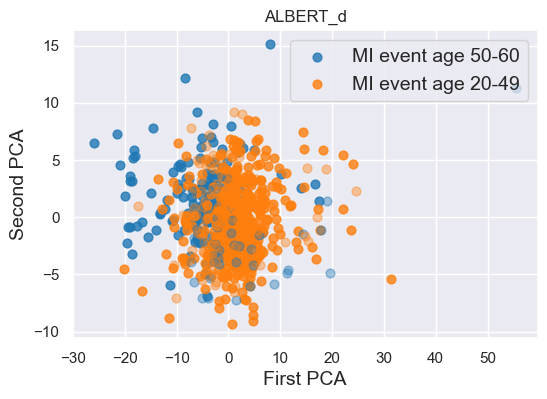

<Figure size 700x500 with 0 Axes>

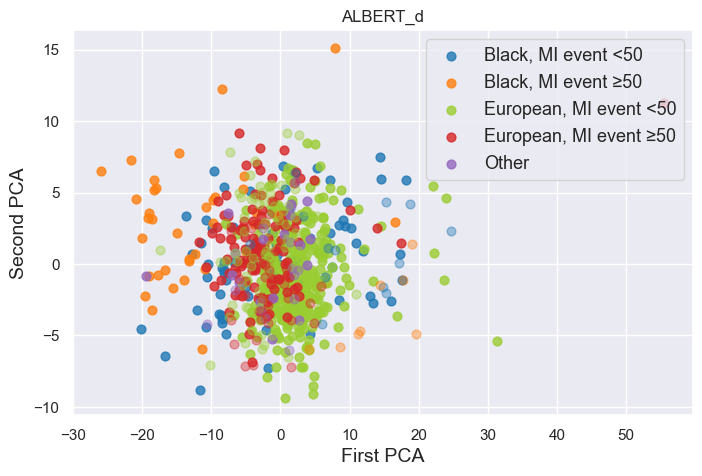

UMAP operation at testing data : 1.0272612571716309


<Figure size 500x500 with 0 Axes>

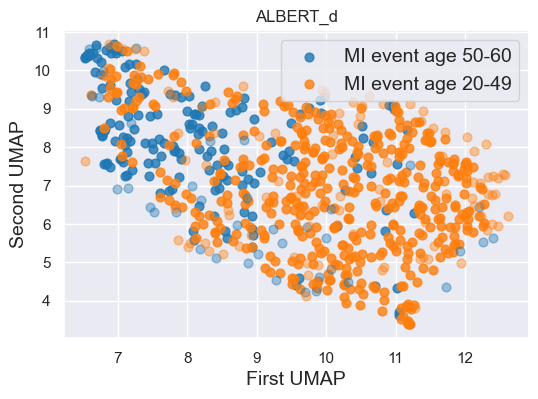

<Figure size 700x500 with 0 Axes>

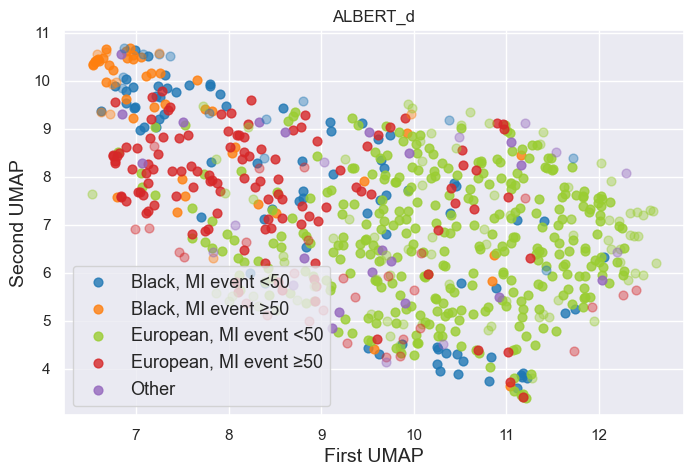

In [12]:
TOPNUMBER=10

eb_names = ['IN', 'OUT', 'Word2Vec', 'GloVe','FastText',\
              'ELMo', 'GPT2', 'ALBERT_i', 'ALBERT_d']

### note: the shape of visualized results may be different per random seed and selected features by feature selection model
### however generally they provide similar results for both qualitative and qualified analysis to our published paper.

for eb_name in eb_names: 
    print('-------------- Embedding for NNDP : ', eb_name)
    words_list, index2word, syn0norm = emb2simi.setting(eb_name, 'heart')
    emb2simi.similarity_display(TOPNUMBER) 
    
    print('arrange the embedding matrix per SNP index')
    embeding_X0, recorded_gene, recoreded_rsid_indexs, removal = sp.connecting_embedding_model(syn0norm, rsid_indexs, RsId2symble, words_list2=words_list)
    X=sp.arranged_X(ori_X.copy().T, removal) 

    index=sp.removing_missing(X)
    X=sp.replacing_indexing(X) 
    X=pd.DataFrame(X).T.drop(index) 
    print('removing SNP that has missing of > 5%')
    embeding_X0 = np.array(pd.DataFrame(embeding_X0).drop(index))
    print('removing some embedding vectors that matached with removed SNP')
    for i, (train_index, test_index) in enumerate(StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1).split(np.array(X).T, y_MI)):
        _X_train = np.array(X).T[train_index]
        y_MI_train = y_MI[train_index]
        y_race_train = y_race[train_index]
        _X_test = np.array(X).T[test_index]
        y_MI_test = y_MI[test_index]
        y_race_test = y_race[test_index] 
    print('spliting data into training and testing sets')

    indices = RF_FS(_X_train, y_MI_train)
    _X_train = np.reshape(_X_train, (_X_train.shape[0], -1)) 
    _X_test = np.reshape(_X_test, (_X_test.shape[0], -1))
    X_train, X_test = Standardization(_X_train[:,indices[:full_size]], _X_test[:,indices[:full_size]])

    y_MI_train = np.squeeze(y_MI_train); y_MI_test = np.squeeze(y_MI_test)   
    y_race_train = np.squeeze(y_race_train); y_race_test = np.squeeze(y_race_test)
    
    y_mixed_train = re_labeling(y_race_train, y_MI_train)
    y_mixed_test = re_labeling(y_race_test, y_MI_test)
    
    LiterSNP1 = Literature_based_SNP(embeding_X0, X_train, full_size, indices)
    LiterSNP2 = Literature_based_SNP(embeding_X0, X_test, full_size, indices)

    Visualization_Analysis(LiterSNP1,y_MI_train, y_mixed_train, LiterSNP2,y_MI_test, y_mixed_test, eb_name)